### Rectify all images on S3 bucket and write to public read bucket

In [1]:
from pathlib import Path
import imageio
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil import tz
import pandas as pd
import glob, os

from coastcam_funcs import *
from calibration_crs import *


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


#### Read the inventory of products

In [2]:
rdir = 'C:\\crs\\src\\dash_doodler\\results\\results2021-02-20-15-46'
c1list = []
c2list = []

for c1path in glob.glob(rdir+'/'+'*c1.timex_label_greyscale*'):
    c1file = os.path.basename(c1path)

    # check to see there is a corresponding c2 file
    c2path = (glob.glob(rdir+'/'+c1file[0:10]+'.c2.timex_label_greyscale*'))[0]
    if c2path:     
        c1list.append(c1file)
        c2file = os.path.basename(c2path)
        c2list.append(c2file)

label_paths = [ rdir+'/'+c1list[0],rdir+'/'+c2list[0]]
print(label_paths)

['C:\\crs\\src\\dash_doodler\\results\\results2021-02-20-15-46/1577188801.c1.timex_label_greyscale2021-02-20-15-49_crs.png', 'C:\\crs\\src\\dash_doodler\\results\\results2021-02-20-15-46/1577188801.c2.timex_label_greyscale2021-02-20-15-53_crs.png']


In [3]:
# this is from ../src/dash_doodler/classes.txt
label_names = ['sky','water','surf','veg','sand']
label_clrs = ['lightblue','blue','gray','green','orange']
    
def sort_labels(labels):
    label_nums = np.unique(labels)
    label_size = np.zeros(len(label_nums))
    for i,label_num in enumerate(label_nums):
        label_size[i]= int(len(labels[labels==label_num]))
    
    sorted_labels = label_nums[np.argsort(-label_size)]
    sorted_size = label_size[np.argsort(-label_size)]
    return sorted_labels, sorted_size

def label_inventory(labels, label_names):
    sorted_labels, sorted_size = sort_labels(labels)
    for i in sorted_labels:
        print('{:}, {:d}, {:.3f}'.format(label_names[i-1],int(sorted_size[i-1]), sorted_size[i-1]/(np.sum(sorted_size))))

In [4]:
print('Camera 1:')
lbl = imageio.imread(label_paths[0])
label_inventory(lbl,label_names)
print('Camera 2:')
lbl = imageio.imread(label_paths[1])
label_inventory(lbl,label_names)

Camera 1:
veg, 628463, 0.125
sand, 232420, 0.046
water, 969784, 0.193
sky, 2432612, 0.485
surf, 750225, 0.150
Camera 2:
veg, 296098, 0.059
water, 907184, 0.181
sand, 185363, 0.037
sky, 2903696, 0.579
surf, 721163, 0.144


### Make a time series of the fraction for each label

Length of image list:  17
Length of label list:  5


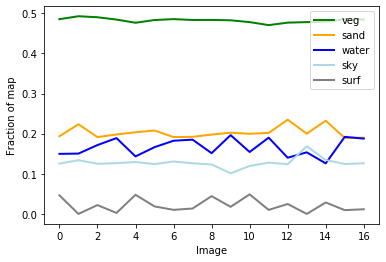

In [5]:
print('Length of image list: ',len(c1list))
print('Length of label list: ',len(label_names))

# Make an array w/ number of labels in each category
labc = np.zeros((len(c1list),len(label_names)))
for i, fn1 in enumerate(c1list):
    lbl = imageio.imread( rdir+'/'+fn1)
    sl, ss = sort_labels(lbl)
    for j in range(len(sl)):
        labc[i,sl[j]-1] = ss[j]
        
# normalize by number of labels per image
nc = lbl.size
labc = labc / nc
        
sky = labc[:,0]
water = labc[:,1]
surf = labc[:,2]
veg = labc[:,3]
sand = labc[:,4]

plt.plot(veg,label='veg',linewidth=2,c=label_clrs[3])
plt.plot(sand,label='sand',linewidth=2,c=label_clrs[4])
plt.plot(water,label='water',linewidth=2,c=label_clrs[1])
plt.plot(sky,label='sky',linewidth=2,c=label_clrs[0])
plt.plot(surf,label='surf',linewidth=2,c=label_clrs[2])
plt.ylabel('Fraction of map')
plt.xlabel('Image')
plt.legend()

### Set up the rectification

In [6]:
# List of files...three for each camera. Calibration parameters are in .json format
# These are the USGS image filename format
extrinsic_cal_files = ['CACO01_C1_EOBest.json','CACO01_C2_EOBest.json']
intrinsic_cal_files = ['CACO01_C1_IOBest.json','CACO01_C2_IOBest.json']

# Dict providing the metadata that the Axiom code infers from the USACE filename format
metadata= {'name': 'CACO-01', 'serial_number': 1, 'camera_number': 'C1', 'calibration_date': '2019-12-12', 'coordinate_system': 'geo'}
# dict providing origin and orientation of the local grid
local_origin = {'x': 410935.,'y':4655890., 'angd': 55.}

# read cal files and make lists of cal dicts
extrinsics_list = []
for f in extrinsic_cal_files:
    extrinsics_list.append( json2dict(f) )
intrinsics_list = []
for f in intrinsic_cal_files:
    intrinsics_list.append( json2dict(f) )
    
# check test for coordinate system
if metadata['coordinate_system'].lower() == 'xyz':
    print('Extrinsics are local coordinates')
elif metadata['coordinate_system'].lower() == 'geo':
    print('Extrinsics are in world coordinates')
else:
    print('Invalid value of coordinate_system: ',metadata['coordinate_system'])
    
print(extrinsics_list[0])
print(extrinsics_list[0]['y']-local_origin['y'])

calibration = CameraCalibration(metadata,intrinsics_list[0],extrinsics_list[0],local_origin)
print(calibration.local_origin)
print(calibration.world_extrinsics)
print(calibration.local_extrinsics)

Extrinsics are in world coordinates
{'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}
52.49000000022352
{'x': 410935.0, 'y': 4655890.0, 'angd': 55.0}
{'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}
{'x': -9.21537219613947, 'y': 104.6744377358444, 'z': 27.3, 'a': 0.6889310885968812, 't': 1.304, 'r': 0.007}


### Functions for rectifying labels
* TODO - Put these in an external .py file
* `TargetGrid` is unchanged...remove from here if `rectify_crs.py` is included.
* The `rectfier` class has been split into standalone functions, renamed, and repurposed to treat 2D arrays, rather than x,y,rgb arrays.

In [7]:
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.morphology import distance_transform_edt

class TargetGrid(object):
    """Grid generated to georectify image.

    CRS modified to make endpoints inclusive
    Notes:
        - Used to maps points in world coordinates to pixels
        - The limits should be specified in local coordinates using the same
          coordinates and units as camera calibrations.

    Args:
        xlims (ndarray) - min and max (inclusive) in the x-direction (e.g. [-50, 650])
        ylims (ndarray) - min and max (inclusive) in the y-direction (e.g. [0, 2501])
        dx (float) - resolution of grid in x direction (same units as camera calibration)
        dy (float) - resolution of grid in y direction (same units as camera calibration)
        z (float) - static value to estimate elevation at everypoint in the x, y grid

    Attributes:
        X (np.ndarray): Local grid coordinates in x-direction.
        Y (np.ndarray): Local grid coordinates in y-direction.
        Z (np.ndarray): Local grid coordinates in z-direction.
        xyz (np.ndarray): The grid where pixels are compiled from images for rectification.
    """
    def __init__(self, xlims, ylims, dx=1, dy=1, z=-0.91):
        x = np.arange(xlims[0], xlims[1]+dx, dx)
        y = np.arange(ylims[0], ylims[1]+dx, dy)
        self.X, self.Y = np.meshgrid(x, y)
        self.Z = np.zeros_like(self.X) + z
        self.xyz = self._xyz_grid()

    def _xyz_grid(self):
        x = self.X.copy().T.flatten()
        y = self.Y.copy().T.flatten()
        z = self.Z.copy().T.flatten()
        return np.vstack((x, y, z)).T
    
def find_distort_UV(target_grid, calibration):
    # get UV for pinhole camera
    xyz = np.vstack((
        target_grid.xyz.T,
        np.ones((len(target_grid.xyz),))
    ))
    UV = np.matmul(calibration.P, xyz)

    # make homogenous
    div = np.tile(UV[2, :], (3, 1))
    UV = UV / div

    # get and rename
    NU = calibration.lcp['NU']
    NV = calibration.lcp['NV']
    c0U = calibration.lcp['c0U']
    c0V = calibration.lcp['c0V']
    fx = calibration.lcp['fx']
    fy = calibration.lcp['fy']
    d1 = calibration.lcp['d1']
    d2 = calibration.lcp['d2']
    d3 = calibration.lcp['d3']
    t1 = calibration.lcp['t1']
    t2 = calibration.lcp['t2']
    u = UV[0, :]
    v = UV[1, :]

    # normalize distances
    x = (u - c0U) / fx
    y = (v - c0V) / fy
    # radial distortion
    r2 = x*x + y*y
    fr = 1. + d1*r2 + d2*r2*r2 + d3*r2*r2*r2
    # tangential distorion
    dx=2.*t1*x*y + t2*(r2+2.*x*x)
    dy=t1*(r2+2.*y*y) + 2.*t2*x*y
    # apply correction, answer in chip pixel units
    xd = x*fr + dx
    yd = y*fr + dy
    Ud = xd*fx+c0U
    Vd = yd*fy+c0V

    # Declare array for flagged values
    flag = np.ones_like(Ud)

    # find negative UV coordinates
    flag[np.where( Ud<0.)]=0.
    flag[np.where( Vd<0.)]=0.
    # find UVd coordinates greater than image size
    flag[np.where( Ud>=NU)]=0.
    flag[np.where( Vd>=NV)]=0.

    # Determine if Tangential Distortion is within Range
    #  Find Maximum possible tangential distortion at corners
    Um=np.array((0, 0, NU, NU))
    Vm=np.array((0, NV, NV, 0))

    # Normalization
    xm = (Um-c0U)/fx
    ym = (Vm-c0V)/fy
    r2m = xm*xm + ym*ym

    # Tangential Distortion
    dxm=2.*t1*xm*ym + t2*(r2m+2.*xm*xm)
    dym=t1*(r2m+2.*ym*ym) + 2.*t2*xm*ym

    # Find Values Larger than those at corners
    flag[np.where(np.abs(dy)>np.max(np.abs(dym)))]=0.
    flag[np.where(np.abs(dx)>np.max(np.abs(dxm)))]=0.

    DU = Ud.reshape(target_grid.X.shape, order='F')
    DV = Vd.reshape(target_grid.Y.shape, order='F')

    # find negative Zc values and add to flag
    UV = np.matmul(calibration.P, xyz)
    xyzC = np.matmul(calibration.R,np.matmul(calibration.IC,xyz))
    flag[np.where(xyzC[2,:]<=0.)]=0.
    flag = flag.reshape(target_grid.X.shape, order='F')

    # apply the flag to zero-out non-valid points
    return DU*flag, DV*flag, flag

def get_labels(target_grid, DU, DV, labels):
    """Return label values for each xyz point from the image

    Arguments:
        DU (np.ndarray): Pixel location in camera orientation and coordinate system
        DV (np.ndarray): Pixel location in camera orientation and coorindate system
        image_labels (np.ndarray [nx,ny]) with integer label values at U,V points
        interpolation will be nearest neighbor to preserve integer values

    Returns:
        K (np.ndarray): Integer image label for each point in the image
    """
    K = np.zeros((
        target_grid.X.shape[0],
        target_grid.X.shape[1]
    ))

    rgi = RegularGridInterpolator(
        (np.arange(0, labels.shape[0]),
         np.arange(0, labels.shape[1])),
        labels[:,:],
        method='nearest',
        bounds_error=False,
        fill_value=0)
    K[:, :] = rgi((DV,DU))

    # mask out values out of range like Matlab
    # avoid runtime nan comparison warning (DU, DV already have nans)
    with np.errstate(invalid='ignore'):
        mask_u = np.logical_or(
            DU <= 1,
            DU >= labels.shape[1]
        )
        mask_v = np.logical_or(
            DV <= 1,
            DV >= labels.shape[0]
        )
    mask = np.logical_or(
        mask_u,
        mask_v
    )
    K[mask] = np.nan
    return K

def rectify_labels(metadata, target_grid, label_files, intrinsic_cal_list, extrinsic_cal_list, local_origin, fs=None):
    """Georectify and blend labels from multiple cameras

    Arguments:
        metadata (dict):
        target_grid: grid object
        label_files (list): List of label files
        intrinsic_cal_list (list): list of paths to internal calibrations (one for each camera)
        extrinsic_cal_list (list): list of paths to external calibrations (one for each camera)
        local_origin:
        fs: (object): fsspec file spec object for folder on S3 bucket. If none, normal file system will be used.

    Returns:
        M (np.ndarray): Georectified images merged from supplied images.
    """
    # array for final pixel values
    #M = np.zeros_like(target_grid.X)
    M = np.zeros((701,501,2))

    for cur_idx, (label_file, intrinsic_cal, extrinsic_cal) in enumerate(zip(label_files, intrinsic_cal_list, extrinsic_cal_list)):
        # load camera calibration file and find pixel locations
        camera_calibration = CameraCalibration(metadata, intrinsic_cal, extrinsic_cal, local_origin)
        U, V, flag = find_distort_UV(target_grid, camera_calibration)

        # load image and apply weights to pixels
        if fs:
            # using fsspec for S3 files
            with fs.open(label_file) as f:
                image = imageio.imread(f)
        else:
            # regular file system
            image = imageio.imread(label_file)

        M[:,:,cur_idx] = get_labels(target_grid, U, V, image)
    
    return M.astype(np.uint8)


In [8]:
xmin = 0.
xmax = 500.
ymin = 0.
ymax = 700.
dx = 1.
dy = 1.
z =  0.

rectifier_grid = TargetGrid(
    [xmin, xmax],
    [ymin, ymax],
    dx,
    dy,
    z
)

In [9]:
M = rectify_labels(metadata, rectifier_grid, label_paths, intrinsics_list, \
                                                extrinsics_list, local_origin )        
Mm = np.maximum(M[:,:,0],M[:,:,1])

print(np.max(Mm))


5


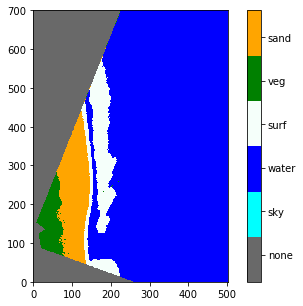

In [10]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(['#696969','#00FFFF', '#0000FF', '#F5FFFA', '#008000', '#FFA500'])
cb_label_names = ['none','sky','water','surf','veg','sand']

fig = plt.figure(figsize=(7,5))
# fig,ax = plt.subplots(1,1,aspect='equal')
plt.pcolor(Mm,cmap=label_cmap,)
plt.gca().set_aspect('equal')
cb=plt.colorbar()
cb.set_ticks(np.linspace(.5, 4.5, 6))
cb.set_ticklabels(cb_label_names)

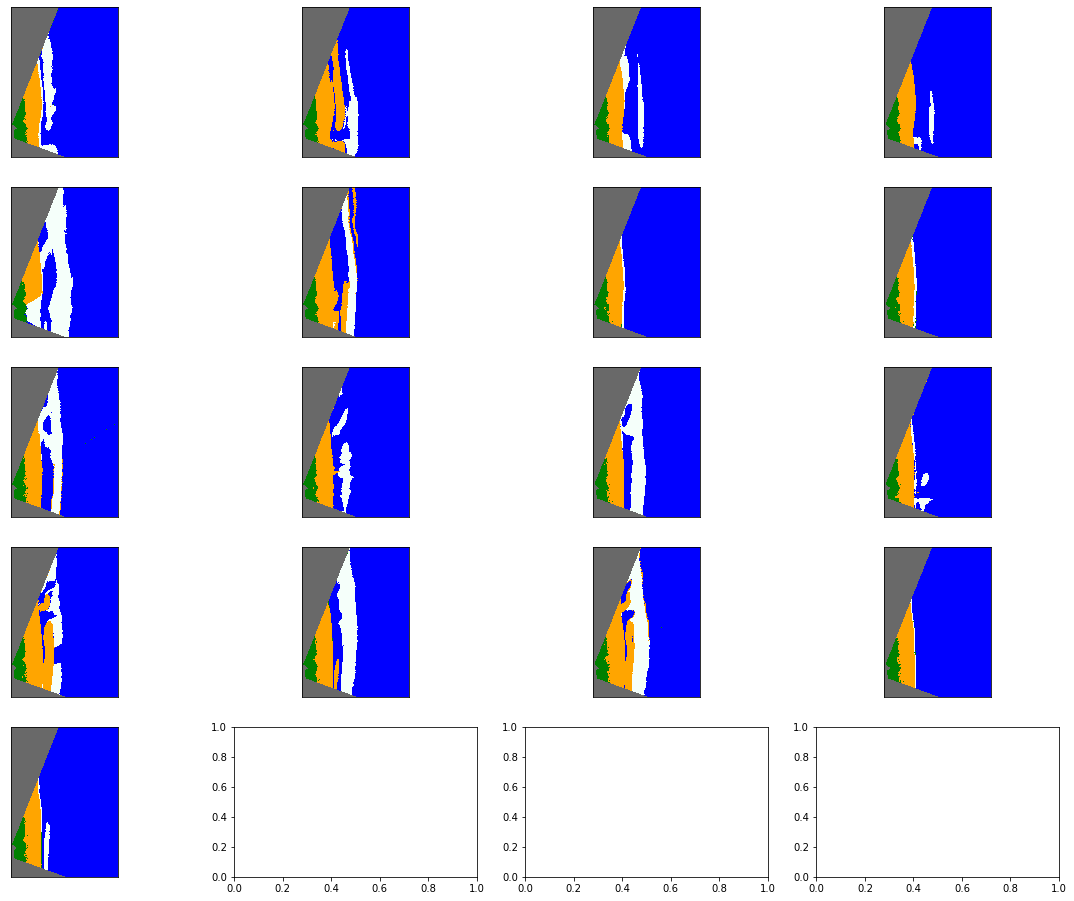

In [11]:
i = 0
fig,ax=plt.subplots(5,4,figsize=(20,16))
ax = ax.ravel()
for fn1, fn2 in (zip(c1list,c2list)):
    label_paths = [ rdir+'/'+fn1, rdir+'/'+fn2 ]
    M = rectify_labels(metadata, rectifier_grid, label_paths, intrinsics_list, \
                                                extrinsics_list, local_origin )        
    Mm = np.maximum(M[:,:,0],M[:,:,1])
    Mm[Mm==1]=3
    #ax[i].subplot(5,4,i+1)
    ax[i].pcolor(Mm,cmap=label_cmap)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal')
    i=i+1